In [1]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt #for visualizations
import seaborn as sns #for visualizations
import pickle


from datetime import datetime 
from nltk.corpus import stopwords # to remove the stopwrods
from nltk.tokenize import word_tokenize #for tokenization
from nltk.stem import WordNetLemmatizer # for lemmitization

from sklearn.model_selection import train_test_split #to divide the corpus in train and test splits 
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score #For analysis
from tqdm.notebook import tqdm


C:\Users\Simon\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#https://www.kaggle.com/rodolfoluna/fake-news-detector
#https://12ft.io/proxy?q=http://towardsdatascience.com/text-classification-in-python-dd95d264c802

In [3]:
# Data is provided in two datasets, so we need to combine them

fake_news = pd.read_csv('Fake.csv')
fake_news['Fake'] = 1

# Load real news
real_news = pd.read_csv('True.csv')
real_news['Fake'] = 0

# Join the two dataframes
news = pd.concat([fake_news, real_news])

In [4]:
news.head()

,title,text,subject,date,Fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [5]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   Fake     44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [6]:
news.describe()

,Fake
count,44898.000000
mean,0.522985
std,0.499477
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [7]:
news.isna().sum()

title      0
text       0
subject    0
date       0
Fake       0
dtype: int64

# Visualise the data

Count of fake: 
1    23481
0    21417
Name: Fake, dtype: int64


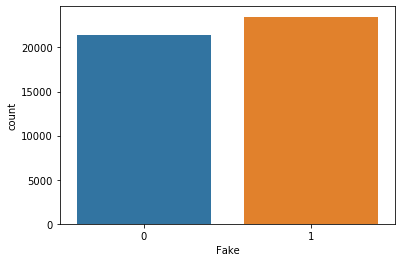

In [8]:
sns.countplot(x='Fake', data=news)
print("Count of fake: \n{}".format(news['Fake'].value_counts()))

# Feature Engineering

In [9]:
news['date'] = pd.to_datetime(news['date'], errors='coerce')
news['Year'] = news['date'].dt.year
news['Month'] = news['date'].dt.month

news.head()

,title,text,subject,date,Fake,Year,Month
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,1,2017.0,12.0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,1,2017.0,12.0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,1,2017.0,12.0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,1,2017.0,12.0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,1,2017.0,12.0


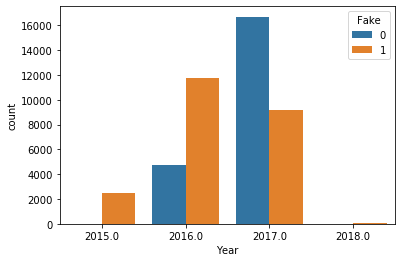

In [10]:
# Check the impact of Year on the target variable
sns.countplot(x='Year', data=news, hue='Fake')

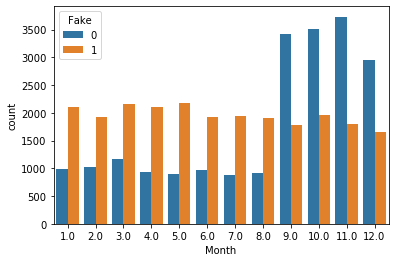

In [11]:
# Check the impact of Month on the target variable
sns.countplot(x='Month', data=news, hue='Fake')

In [12]:
#We want all information of an article, which would be the title, text and subject
news['Article'] = news['title']+""+news['text']+""+['subject']

In [13]:
final_news = news[['Article', 'Fake']]

# Prepare Data

## Lower and remove punctutation

In [14]:
final_news['Article'] = final_news['Article'].apply(lambda x: x.lower())

C:\Users\Simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
final_news.head()

,Article,Fake
0,donald trump sends out embarrassing new year’...,1
1,drunk bragging trump staffer started russian ...,1
2,sheriff david clarke becomes an internet joke...,1
3,trump is so obsessed he even has obama’s name...,1
4,pope francis just called out donald trump dur...,1


In [16]:
# remove punctutations
def remove_punct(input_string):
    split_article = [char for char in input_string if char not in string.punctuation]
    clean_article = ''.join(split_article)
    return clean_article

In [17]:
final_news['Article'] = final_news['Article'].apply(remove_punct)

C:\Users\Simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
final_news['Article'].head() 

0     donald trump sends out embarrassing new year’...
1     drunk bragging trump staffer started russian ...
2     sheriff david clarke becomes an internet joke...
3     trump is so obsessed he even has obama’s name...
4     pope francis just called out donald trump dur...
Name: Article, dtype: object

# Tokenize

In [19]:
for article in tqdm(final_news['Article']):
    #word_tokenize is a function from the nltk.tokenize package
    tokenized_article = word_tokenize(article)

  0%|          | 0/44898 [00:00<?, ?it/s]

## Stopwords

In [20]:
stopWords = stopwords.words('english')
filtered_document = []
filtered_article = []
#final_news['Article'].apply(lambda x: [item for item in tqdm(x) if item not in stopWords])

for sentence in tqdm(final_news['Article']):
    #Having taken a sentence, remove the stopwords of that sentence
    for word in sentence:
        if word not in stopWords:
            #save the tokenized, stopword-less article in a list
            filtered_article.append(word)
    sentence = filtered_article
    
    #Add the filtered sentence to the overal documents list
    #filtered_document.append(sentence)
    
    #reset the sentence list so that we do not accidently save multiple articles as one article
    #filtererd_article = []
    

  0%|          | 0/44898 [00:00<?, ?it/s]

## Lemmatization

In [21]:
# Lemmatization function

lemmatizer = WordNetLemmatizer()

def lemmatize_text(article):
    #lemmatize each word in the article
    return [lemmatizer.lemmatize(word) for word in article]  
    

In [22]:
# call the lemmatization function on each sentence in the corpus
#Cleaned_articles = []

for article in tqdm(final_news['Article']):
    #this might go wrong --> the input is a list of tokenized words, so this might return individual lemmatized words
    # Might also go wrong by not being able to lemmatize a text --> would need to go one layer deeper
    lemmatizing_sentences = lemmatize_text(article)
    ##Cleaned_articles.append(lemmatizing_sentences)

  0%|          | 0/44898 [00:00<?, ?it/s]

In [25]:
final_news.head()

,Article,Fake
0,donald trump sends out embarrassing new year’...,1
1,drunk bragging trump staffer started russian ...,1
2,sheriff david clarke becomes an internet joke...,1
3,trump is so obsessed he even has obama’s name...,1
4,pope francis just called out donald trump dur...,1


In [26]:
for article in final_news["Article"]:
    article = final_news["Article"].array

In [27]:
X = final_news["Article"]
Y = final_news["Fake"]

In [28]:
Y

0        1
1        1
2        1
3        1
4        1
        ..
21412    0
21413    0
21414    0
21415    0
21416    0
Name: Fake, Length: 44898, dtype: int64

In [29]:
X

0         donald trump sends out embarrassing new year’...
1         drunk bragging trump staffer started russian ...
2         sheriff david clarke becomes an internet joke...
3         trump is so obsessed he even has obama’s name...
4         pope francis just called out donald trump dur...
                               ...                        
21412    fully committed nato backs new us approach on ...
21413    lexisnexis withdrew two products from chinese ...
21414    minsk cultural hub becomes haven from authorit...
21415    vatican upbeat on possibility of pope francis ...
21416    indonesia to buy 114 billion worth of russian ...
Name: Article, Length: 44898, dtype: object

# Build the model

### Bag of words model

Bag of words uses the occurences of words in the corpus. This is a great baseline and a surprisingly effective model for its simplicity

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Occurence_vector = TfidfVectorizer()
fitted_X = Occurence_vector.fit_transform(X)
Occurence_vector.get_feature_names_out() 


array(['00', '000', '0000', ..., 'émigré', 'état', 'žižek'], dtype=object)

In [31]:
# open a file, where you ant to store the data
file = open('fitted_X', 'wb')

# dump information to that file
pickle.dump(fitted_X, file)

# close the file
file.close()

In [32]:
fitted_X.shape

(44898, 248247)

In [36]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(fitted_X, Y, test_size= 0.2, random_state= 1)

# SVM

In [37]:
#SVM model

from sklearn import svm
svm_model = svm.SVC()
svm_model.fit(x_train, y_train)


Model Fit:: |          | 0/? [00:00<?, ?it/s]

Model Fit:: 0it [00:00, ?it/s]

In [38]:
svm_prediction = svm_model.predict(x_test)


In [39]:
np.mean(svm_prediction == y_test)

0.9928730512249443

# LR

In [40]:
#Logistic regression model

In [44]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression(random_state=1).fit(x_train, y_train)
LR_prediction = LR_model.predict(x_test)


In [45]:
np.mean(LR_prediction == y_test)

0.9874164810690423

# XGBoost

In [43]:
#XGBoost (XGBClassifier)

# Evaluation